In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import pandas as pd
import pandas as pd
import cv2
import numpy as np
import os


In [2]:
#pfade
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed images/'
mask_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Masken/'
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Models/spheroid_segmentation_200_trainingsbilder_komplex.h5'
beispielbild = 'C/Users/chris/Master/Sphaeroidauswertung/Input_Bilder/Sphaeroid8.tif'
input_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Input_Bilder/'
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder/'

In [3]:
#Variablen

def vorverarbeiten_masken(mask_path):
    mask = Image.open(mask_path)
    mask = mask.resize((256, 196))  # Größe anpassen (Beispiel: 256x256)
    mask = np.array(mask)  # PIL Image zu numpy Array konvertieren
    mask = np.where(mask > 128, 1, 0)  # Binarisierung der Maske
    mask = np.expand_dims(mask, axis=-1)  # Für einen Kanal (Grayscale)
    return mask


# Vorhersage mit dem Modell machen
def predict_with_model(model, image, threshold=0.15):
    # Dimension für Batch hinzufügen, da das Modell ein Batch erwartet
    image = np.expand_dims(image, axis=0)
    # Vorhersage machen
    predicted_mask = model.predict(image)
    # Binarisieren basierend auf der Schwelle
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)
    return np.squeeze(predicted_mask)  # Batch-Dimension und Kanal-Dimension entfernen

# Funktion zur Berechnung des mittleren Durchmessers einer Kontur
def calculate_average_diameter(contour, center, num_lines=360):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

In [8]:
#trainieren des modells für die segmentierung der sphaeroide
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Pfade zu den Bildern und Masken

# Liste der Bild- und Maskenpfade
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])



# Liste für Bilder und Masken initialisieren
X = []
Y = []

# Bilder und Masken laden und in die Listen einfügen
for img_path, mask_path in zip(image_paths, mask_paths):
    img = Image.open(img_path)
    mask = vorverarbeiten_masken(mask_path)
    X.append(img)
    Y.append(mask)
    
# In NumPy Arrays konvertieren
X = np.array(X)
Y = np.array(Y)

# Überprüfen der Formen (optional)
print(f'Form von X vorher: {X.shape}')
print(f'Form von Y vorher: {Y.shape}')

# Modell erstellen
model = Sequential([
    Conv2D(64, 3, activation='relu', padding='same', input_shape=(196, 256, 1)),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

# Adam-Optimizer mit spezifischer Lernrate erstellen
optimizer = Adam(learning_rate=0.0001)

# Modell kompilieren mit dem Adam-Optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Trainieren des Modells
history = model.fit(X, Y, batch_size=8, epochs=50, validation_split=0.2)

# Pfad zum Speichern des Modells im HDF5-Format
model.save('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_3.h5') 




# Überprüfen der Formen (optional)
print(f'Form von X nachher: {X.shape}')
print(f'Form von Y nachher: {Y.shape}')


Form von X vorher: (42, 196, 256, 1)
Form von Y vorher: (42, 196, 256, 1)
Epoch 1/50


c:\Users\chris\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.6847 - val_loss: 0.6584
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.6533 - val_loss: 0.6202
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.6150 - val_loss: 0.5703
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 963ms/step - loss: 0.5628 - val_loss: 0.5065
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.4930 - val_loss: 0.4405
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.4209 - val_loss: 0.4036
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 982ms/step - loss: 0.3575 - val_loss: 0.4267
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 970ms/step - loss: 0.3473 - val_loss: 0.4728
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 981ms/step - loss: 0.3641 - val_loss: 0.4685
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 939ms/step - loss: 0.3649 - val_loss: 0.4431
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 956ms/step - loss: 0.3389 - val_loss: 0.4247
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 958ms/step - loss: 0.3523 - val_loss: 0.4169
Epoch 13/50
5/5

Form von X nachher: (42, 196, 256, 1)
Form von Y nachher: (42, 196, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Segmentiertes Bild für Sphaeroid8.tif wurde gespeichert.
Alle Bilder wurden segmentiert und gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


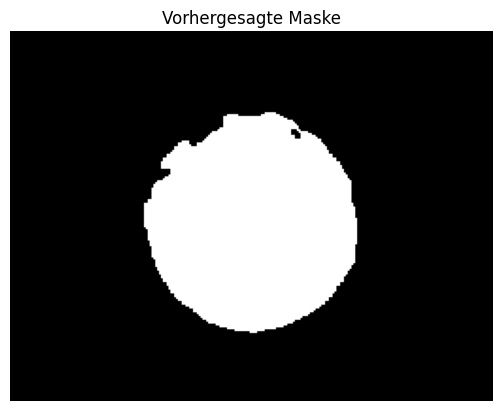

In [12]:

  

# Hauptprogramm
if __name__ == "__main__":
    # Pfad zum Modell und Beispielbild

    
    # Modell laden
    model = tf.keras.models.load_model(model_path)
    
    # Eingabe- und Ausgabeverzeichnisse definieren

    
    # Liste aller TIFF-Dateien im Eingabeordner
    tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]
    
    # Iteration über alle TIFF-Dateien
    for filename in tif_files:
        # Pfad zum aktuellen Bild
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            img = Image.open(img_path)
            
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)
            
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue
            
            # Ausgabepfad für das segmentierte Bild definieren
            output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
            
            # Maske als TIFF-Datei speichern
            Image.fromarray((predicted_mask * 255).astype(np.uint8), mode='L').save(output_path)
        
            print(f"Segmentiertes Bild für {filename} wurde gespeichert.")
        
        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {filename}: {str(e)}")
    
    print("Alle Bilder wurden segmentiert und gespeichert.")
    
    try:
        # Beispielbild laden und vorverarbeiten
        example_image = vorverarbeiten_bilder(beispielbild)
        
        # Vorhersage mit dem Modell machen
        predicted_mask = predict_with_model(model, example_image)
        
        if predicted_mask is None:
            print(f"Fehler bei der Vorhersage für das Beispielbild {image_path}.")
        else:
            # Vorhersage visualisieren
            plt.imshow(predicted_mask, cmap='gray') # type: ignore
            plt.title('Vorhergesagte Maske')
            plt.axis('off')
            plt.show()
                         
    except Exception as e:
        print(f"Fehler bei der Verarbeitung des Beispielbilds: {str(e)}")


Bild: JES_Spaeroide_WTCII_Methocell_1000-5000 Zellen_E7_4000 Zellem_ Sphaeroid_20x_240705_ch00_segmentiert.tif.tif, Durchmesser: 223.60 µm, Flächeninhalt: 38393.33 µm²


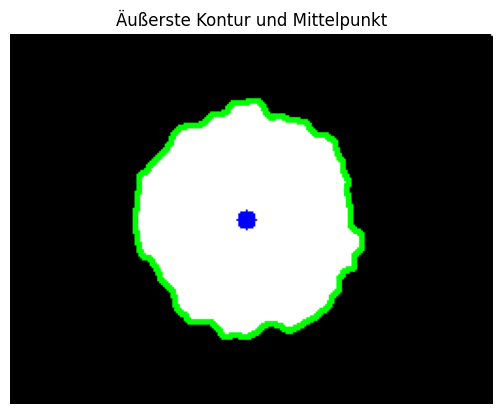

Die Ergebnisse wurden in die Excel-Datei 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/ergebnisse.xlsx' geschrieben.


In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random  # Import der random Bibliothek für die Zufallsauswahl

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# Ordnerpfad mit den Bildern
folder_path = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder/"

# Ergebnisse speichern
results = []


# Zufällige Auswahl von Bildern für die Anzeige
random.seed(42)  # Festlegen des Seeds für die Reproduzierbarkeit
sample_size = 1  # Anzahl der Beispielbilder, die angezeigt werden sollen
sample_images = random.sample(os.listdir(folder_path), sample_size)

# Iteration über die ausgewählten Beispielbilder
for file_name in sample_images:
    # Voller Pfad zum aktuellen Bild
    image_path = os.path.join(folder_path, file_name)

    # Überprüfen, ob die Datei eine Bilddatei ist
    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
        print(f"Überspringe Datei {file_name}, da es keine unterstützte Bilddatei ist.")
        continue

    # Bild laden
    im = cv2.imread(image_path)  # raw RGB image

    # Überprüfen, ob das Bild erfolgreich geladen wurde
    if im is None:
        print(f"Warnung: Das Bild {file_name} konnte nicht geladen werden.")
        continue

    # In Graustufen umwandeln
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Gaussian Blur anwenden, um Einbuchtungen zu verringern
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Binärbild erstellen
    _, im_bw = cv2.threshold(im_gray, 127, 255, cv2.THRESH_BINARY)

    # Konturen finden
    contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        print(f"Warnung: Keine Konturen im Bild {file_name} gefunden.")
        continue

    # Die größte Kontur nach dem Flächeninhalt finden
    largest_contour = max(contours, key=cv2.contourArea)

    # Berechne den Schwerpunkt der Kontur
    M = cv2.moments(largest_contour)
    if M["m00"] == 0:
        print(f"Warnung: Schwerpunkt konnte im Bild {file_name} nicht berechnet werden.")
        continue
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    # Berechne den mittleren Durchmesser
    avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
    avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width)

    # Berechnung des Flächeninhalts
    area_pixels = cv2.contourArea(largest_contour)
    area_micrometers = area_pixels * (0.3745 * scale_factor_width * 0.3745 * scale_factor_height)

    # Ergebnisse hinzufügen
    results.append({
        'Bildname': file_name,
        'Durchmesser (µm)': avg_diameter_micrometers,
        'Flächeninhalt (µm²)': area_micrometers
    })

    # Ergebnisse ausgeben
    print(f"Bild: {file_name}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Flächeninhalt: {area_micrometers:.2f} µm²")

    # Konturen und Mittelpunkt zeichnen
    cv2.drawContours(im, [largest_contour], -1, (0, 255, 0), 2)
    cv2.circle(im, center, 5, (255, 0, 0), -1)

    # Bild anzeigen
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title('Äußerste Kontur und Mittelpunkt')
    plt.axis('off')
    plt.show()

# Ergebnisse als DataFrame konvertieren
df = pd.DataFrame(results)

# Excel-Datei erstellen und Ergebnisse speichern, Duplikate vermeiden
excel_file = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/ergebnisse.xlsx'
df.to_excel(excel_file, index=False)

print(f"Die Ergebnisse wurden in die Excel-Datei '{excel_file}' geschrieben.")


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import cv2

# Funktion zum Laden von Bildern mit Pillow und OpenCV
def load_image(image_path):
    try:
        # Versuche, das Bild mit Pillow zu laden
        with Image.open(image_path) as img:
            img = img.convert('L')  # In Graustufen konvertieren
            img = np.array(img)  # In ein NumPy-Array umwandeln
            return img
    except Exception as e:
        print(f"Pillow konnte das Bild nicht laden ({image_path}): {e}")
        try:
            # Wenn Pillow fehlschlägt, versuche es mit OpenCV
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            return img
        except Exception as e:
            print(f"OpenCV konnte das Bild nicht laden ({image_path}): {e}")
            return None

# Funktion zur Berechnung des mittleren Durchmessers einer Kontur
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters) if diameters else 0

# Funktion zur Bildverarbeitung
def process_image_with_threshold(image_path, threshold_value, center_x, center_y, pixel_to_micrometer_ratio):
    img = load_image(image_path)
    if img is None:
        print(f"Fehler beim Laden des Bildes: {image_path}")
        return [], None

    _, th = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    img = img / 255

    # Anwenden von Gaussian Blur
    blurred = cv2.GaussianBlur(th, (3, 3), 0)

    kernel_open = np.ones((1, 1), np.uint8)
    cleaned = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel_open)
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    spheroids = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if (center_x - w // 2 <= x <= center_x + w // 2) and (center_y - h // 2 <= y <= center_y + h // 2):
            aspect_ratio = float(w) / h
            if aspect_ratio <= 1.2:
                area_pixels = cv2.contourArea(contour)
                area_micrometers = area_pixels * (pixel_to_micrometer_ratio ** 2)
                roundness = 4 * np.pi * area_pixels / (cv2.arcLength(contour, True) ** 2)  # Rundheit

                # Berechne den Schwerpunkt der Kontur
                M = cv2.moments(contour)
                if M["m00"] == 0:
                    continue
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                # Sphäroid identifiziert, durchschnittlicher Durchmesser später berechnet
                spheroids.append((contour, area_micrometers, roundness, center))

    return spheroids, cleaned

# Funktion zur Bewertung der Segmentierungsqualität
def evaluate_segmentation_quality(spheroids):
    if not spheroids:
        return 0, None
    largest_spheroid = max(spheroids, key=lambda s: s[1])  # Größter Flächeninhalt
    quality = largest_spheroid[2]  # Rundheit als Qualitätsmaß
    return quality, largest_spheroid

# Funktion zur Verarbeitung eines Bildordners und Speichern der Ergebnisse
def process_folder(input_folder, output_folder, pixel_to_micrometer_ratio, excel_file_path):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    results = []

    for filename in os.listdir(input_folder):
        if filename.endswith('.tif') or filename.endswith('.png') or filename.endswith('.jpg'):
            image_path = os.path.join(input_folder, filename)
            img = load_image(image_path)
            if img is None:
                print(f"Fehler beim Laden des Bildes: {image_path}")
                continue

            height, width = img.shape
            center_x, center_y = width // 2, height // 2

            # Hyperparameter-Suche (Schwellenwertoptimierung)
            best_threshold = None
            best_quality = 0
            best_cleaned = None
            best_spheroids = None
            best_largest_spheroid = None

            threshold_ranges = [
                range(50, 201, 1),  # Erste Schwellenwertbereich
                range(200, 256, 1),  # Zweiter Schwellenwertbereich, falls der erste Bereich nicht erfolgreich ist
                range(0, 50, 1)  # Dritter Schwellenwertbereich, falls der zweite Bereich nicht erfolgreich ist
            ]

            for threshold_range in threshold_ranges:
                for threshold_value in threshold_range:
                    spheroids, cleaned = process_image_with_threshold(image_path, threshold_value, center_x, center_y, pixel_to_micrometer_ratio)
                    quality, largest_spheroid = evaluate_segmentation_quality(spheroids)
                    if quality > best_quality:
                        best_quality = quality
                        best_threshold = threshold_value
                        best_cleaned = cleaned
                        best_spheroids = spheroids
                        best_largest_spheroid = largest_spheroid
                if best_spheroids:
                    break

            if best_spheroids is None:
                print(f'Bild: {filename} - Kein passender Schwellenwert gefunden.')
                # Ergebnis mit Durchmesser 0 und Bild speichern
                results.append({
                    'Bildname': filename,
                    'Sphäroid': 1,
                    'Durchmesser (µm)': 0,
                    'Flächeninhalt (µm²)': 0,
                    'Rundheit': 0
                })

                # Bild ohne erkannte Konturen speichern
                image_with_spheroids = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                output_image_path = os.path.join(output_folder, f'{os.path.splitext(filename)[0]}_no_contours.png')
                cv2.imwrite(output_image_path, image_with_spheroids)
                continue

            print(f'Bild: {filename}, Bester Schwellenwert: {best_threshold} mit Qualitätsmaß {best_quality}')

            # Berechnung des durchschnittlichen Durchmessers nach Identifizierung der Sphäroide
            for i in range(len(best_spheroids)):
                contour, area, roundness, center = best_spheroids[i]
                avg_diameter_pixels = calculate_average_diameter(contour, center)
                avg_diameter_micrometers = avg_diameter_pixels * pixel_to_micrometer_ratio
                best_spheroids[i] = (contour, avg_diameter_micrometers, area, roundness)
                
                # Ergebnis zur Liste hinzufügen
                results.append({
                    'Bildname': filename,
                    'Sphäroid': i + 1,
                    'Durchmesser (µm)': avg_diameter_micrometers,
                    'Flächeninhalt (µm²)': area,
                    'Rundheit': roundness
                })

            # Bild mit erkannten Sphäroiden erstellen
            image_with_spheroids = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            for contour, _, _, _ in best_spheroids:
                cv2.drawContours(image_with_spheroids, [contour], -1, (0, 255, 0), 2)

            # Ergebnisse speichern
            output_image_path = os.path.join(output_folder, f'{os.path.splitext(filename)[0]}_processed.png')
            cv2.imwrite(output_image_path, image_with_spheroids)

    # Ergebnisse in eine Excel-Datei speichern
    df = pd.DataFrame(results)
    df.to_excel(excel_file_path, index=False)
    print(f'Ergebnisse in {excel_file_path} gespeichert.')

# Ordnerpfade
input_folder = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
output_folder = r'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_opencv'
excel_file_path = r'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/ergebnisse_opencv.xlsx'
pixel_to_micrometer_ratio = 0.37471451

# Verarbeitung des Ordners
process_folder(input_folder, output_folder, pixel_to_micrometer_ratio, excel_file_path)


Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00_processed.tif, Bester Schwellenwert: 70 mit Qualitätsmaß 0.30117036037444733
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00_processed.tif, Bester Schwellenwert: 72 mit Qualitätsmaß 0.18153467914609978
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS +P1 E6_ch00_processed.tif, Bester Schwellenwert: 75 mit Qualitätsmaß 0.30082871782556847
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS B4_ch00_processed.tif, Bester Schwellenwert: 49 mit Qualitätsmaß 0.17921737020259923
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS C4_ch00_processed.tif, Bester Schwellenwert: 74 mit Qualitätsmaß 0.3299184109806323
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS D4_ch00_processed.tif, Bester Schwellenwert: 70 mit Qualitätsmaß 0.3069756164789952
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + P1 B5_ch00_processed.tif, Bester Schwellenwert: 63 mit Qualitätsmaß 0.29557815059567993
Bild: 001_CQ Sphaeroide T

In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Pfade zu den Excel-Dateien
predicted_excel_file_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/ergebnisse_opencv.xlsx'
manual_excel_file_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'

# Laden der Excel-Dateien
predicted_df = pd.read_excel(predicted_excel_file_path)
manual_df = pd.read_excel(manual_excel_file_path)

# Überprüfen der Spaltennamen
print(predicted_df.head())
print(manual_df.head())

# Angenommene Spaltennamen
# In `predicted_df` sind die Spalten: Bildname, Sphäroid, Durchmesser (µm), Flächeninhalt (µm^2), Rundheit
# In `manual_df` sind die Spalten: mittlerer_durchmesser, Bild Nr.

# Umbenennen der Spalten in `manual_df` damit sie übereinstimmen
manual_df.columns = ['Bildname', 'mittlerer_durchmesser']

# Sicherstellen, dass die Spalte 'Bildname' in beiden DataFrames als String vorliegt
predicted_df['Bildname'] = predicted_df['Bildname'].astype(str)
manual_df['Bildname'] = manual_df['Bildname'].astype(str)

# Zusammenführen der Daten basierend auf Bildnamen
merged_df = pd.merge(predicted_df[['Bildname', 'Durchmesser (µm)']], manual_df, on='Bildname')

# Überprüfen, ob die Anzahl der Vorhersagen und der manuellen Werte übereinstimmt
if len(merged_df) == 0:
    print("Keine gemeinsamen Bildnamen gefunden.")
else:
    # Berechnen der Abweichungen und R^2
    y_true = merged_df['mittlerer_durchmesser']
    y_pred = merged_df['Durchmesser (µm)']

    mean_abs_error = mean_absolute_error(y_true, y_pred)
    r_squared = r2_score(y_true, y_pred)

    # Ergebnisse ausgeben
    print(f"Mittelwertliche absolute Abweichung (MAE): {mean_abs_error:.2f} µm")
    print(f"Bestimmtheitsmaß R^2: {r_squared:.2f}")

    # Scatterplot erstellen
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Vorhersagen vs. Tatsächliche Werte')
    plt.xlabel('Handgemessene Durchmesser (µm)')
    plt.ylabel('Vorhergesagte Durchmesser (µm)')
    plt.title('Vergleich der handgemessenen Durchmesser mit den vorhergesagten Durchmessern')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfekte Vorhersage')
    plt.legend()
    plt.grid(True)
    plt.show()


                                            Bildname  Sphäroid  \
0  001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS...         1   
1  001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS...         1   
2  001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS...         1   
3  001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS...         1   
4  001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS...         1   

   Durchmesser (µm)  Flächeninhalt (µm²)  Rundheit  
0         72.470149          4085.256998  0.301170  
1         68.838033          3568.965883  0.181535  
2         74.471808          4330.344335  0.300829  
3          8.286676            55.883564  0.179217  
4         75.487980          4501.013862  0.329918  
   mittlerer_durchmesser  Bild Nr.
0             156.311429         1
1             156.500000         2
2             147.500000         3
3             161.250000         4
4             158.000000         5
Keine gemeinsamen Bildnamen gefunden.
